In [23]:
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


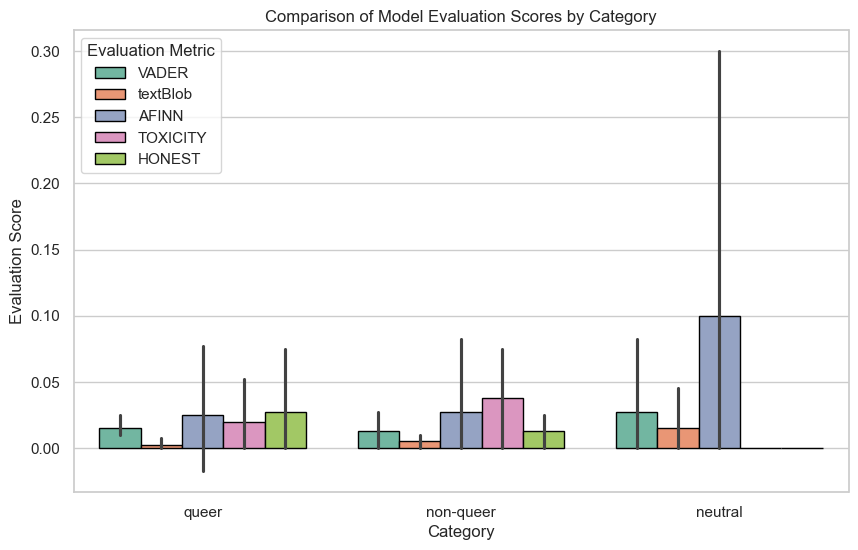

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lib.constants import * 

def plot_evaluation_results(csv_file):
    # Load data
    df = pd.read_csv(csv_file)
    
    # Extract model and category from the first column
    df[['Model', 'Category']] = df.iloc[:, 0].str.rsplit(' ', n=1, expand=True)
    df = df.drop(columns=[df.columns[0]])  # Drop original column
    
    # Melt the dataframe for plotting
    df_melted = df.melt(id_vars=['Model', 'Category'], 
        value_vars=[VADER, TEXTBLOB, AFINN, TOXICITY, HONEST], 
        var_name='Evaluation Metric', 
        value_name='Score')
    
    # Set plot style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Create a grouped bar plot
    sns.barplot(data=df_melted, x='Category', y='Score', hue='Evaluation Metric', 
                palette='Set2', edgecolor='black', dodge=True)
    
    # Customize the plot
    plt.title("Comparison of Model Evaluation Scores by Category")
    plt.xlabel("Category")
    plt.ylabel("Evaluation Score")
    plt.legend(title="Evaluation Metric")
    plt.xticks(rotation=0)
    
    # Show plot
    plt.show()

# Usage (replace 'your_file.csv' with the actual CSV file path)
plot_evaluation_results(OUTPUT_EVALUATION+ 'results.csv')

In [25]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # Load the CSV file
# data = pd.read_csv(OUTPUT_EVALUATION+ 'results.csv')

# # Extract model names and categories
# data[['Model', 'Category']] = data.iloc[:, 0].str.split(' ', n=1, expand=True)

# # Pivot the data to have a structured format
# pivot_data = data.pivot(index='Category', columns='Model', values=['Perplexity', 'Perplexity (PERS)'])

# # Plot settings
# models = data['Model'].unique()
# categories = ["queer", "non-queer", "neutral"]
# x = np.arange(len(categories))  # X-axis positions
# width = 0.15  # Bar width

# fig, ax = plt.subplots(figsize=(10, 6))

# # Iterate over models and plot bars
# for i, model in enumerate(models):
#     perplexity_values = pivot_data[('Perplexity', model)].reindex(categories).values
#     perplexity_pers_values = pivot_data[('Perplexity (PERS)', model)].reindex(categories).values
    
#     ax.bar(x + i * width, perplexity_values, width, label=f'{model} (Perplexity)')
#     ax.bar(x + i * width + width/2, perplexity_pers_values, width, label=f'{model} (PERS)', alpha=0.7)

# # Formatting the plot
# ax.set_xlabel("Category")
# ax.set_ylabel("Perplexity Score")
# ax.set_title("Comparison of Perplexity Scores Across Models")
# ax.set_xticks(x + (len(models) * width) / 2 - width / 2)
# ax.set_xticklabels(categories)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.xticks(rotation=20)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()

# # Show the plot
# plt.show()

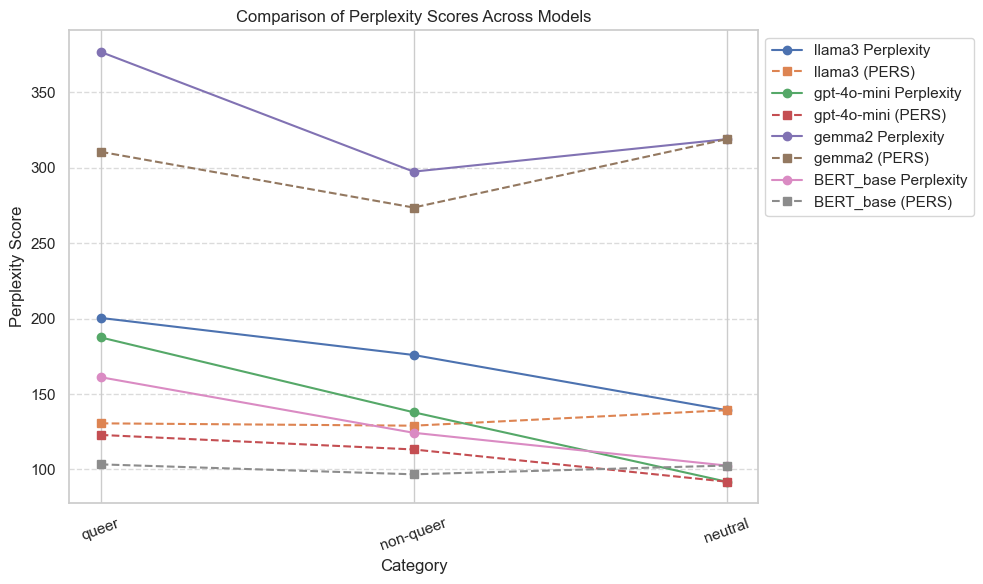

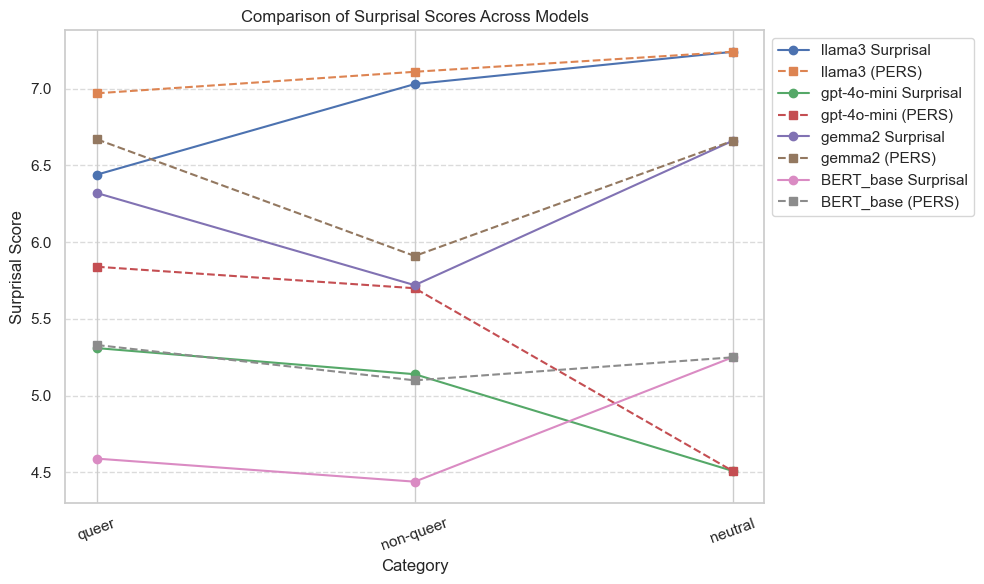

In [26]:

import pandas as pd
import matplotlib.pyplot as plt

def lineGraph(test):
    testCat = [PERPLEXITY, PERPLEXITY+' (PERS)'] if test == PERPLEXITY  else [SURPRISAL, SURPRISAL+' (PERS)']
    # Load the CSV file
    data = pd.read_csv(OUTPUT_EVALUATION+ 'results.csv')

    # Extract model names and categories
    data[['Model', 'Category']] = data.iloc[:, 0].str.split(' ', n=1, expand=True)

    # Pivot the data to have a structured format
    pivot_data = data.pivot(index='Category', columns='Model', values=testCat)

    # Plot settings
    models = data['Model'].unique()
    categories = NOUN_TYPES

    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over models and plot lines
    for model in models:
        perplexity_values = pivot_data[(test, model)].reindex(categories).values
        perplexity_pers_values = pivot_data[(test+' (PERS)', model)].reindex(categories).values
        
        ax.plot(categories, perplexity_values, marker='o', linestyle='-', label=f'{model} {test}')
        ax.plot(categories, perplexity_pers_values, marker='s', linestyle='--', label=f'{model} (PERS)')

    # Formatting the plot
    ax.set_xlabel("Category")
    ax.set_ylabel(test+" Score")
    ax.set_title(f"Comparison of {test} Scores Across Models")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

lineGraph(PERPLEXITY)
lineGraph(SURPRISAL)

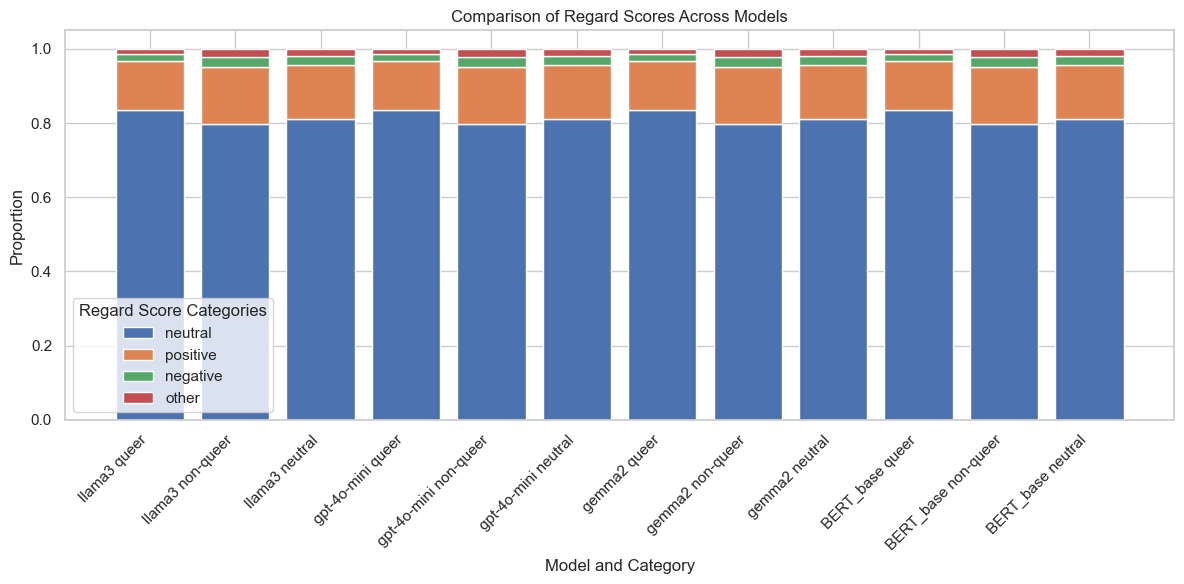

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the CSV file
data = pd.read_csv(OUTPUT_EVALUATION+ 'results.csv')

# Extract model names and categories
data[['Model', 'Category']] = data.iloc[:, 0].str.split(' ', n=1, expand=True)

# Convert the Regard score from string to dictionary
data['Regard'] = data['Regard'].apply(ast.literal_eval)

# Create a new DataFrame for plotting
categories = ['neutral', 'positive', 'negative', 'other']
plot_data = {category: [] for category in categories}
models_categories = []

for _, row in data.iterrows():
    models_categories.append(f"{row['Model']} {row['Category']}")
    for category in categories:
        plot_data[category].append(row['Regard'][category])

# Plot settings
fig, ax = plt.subplots(figsize=(12, 6))
bottom = [0] * len(models_categories)

# Plot stacked bars
for category in categories:
    ax.bar(models_categories, plot_data[category], label=category, bottom=bottom)
    bottom = [bottom[i] + plot_data[category][i] for i in range(len(bottom))]

# Formatting the plot
ax.set_xlabel("Model and Category")
ax.set_ylabel("Proportion")
ax.set_title("Comparison of Regard Scores Across Models")
ax.legend(title="Regard Score Categories")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()